## Project 2 - Image Classification

This network will attempt to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The dataset consists of airplanes, dogs, cats, and other objects. The data will be preprocessed, and then run through a convolutional neural network. Accuracy for this architecture is expected to be ~ 50% to 70% .

In [1]:
import data_get
import problem_unittests as tests

# Import CIFAR-10 Data set
cifar10_dataset_folder_path = data_get.retrieve()

## Exploring the data


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


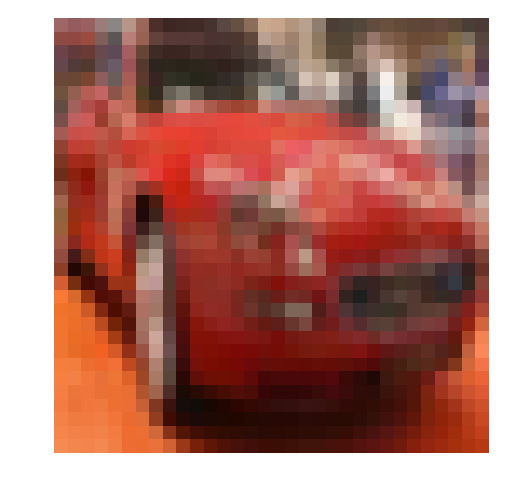

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocessing Functions

### Normalize
Function below takes in image data, and returns it as a normalized numpy array. Values should be within the range 0 to 1, inclusive. Return object is same shape as input object.

In [3]:
def normalize(x):
    in_vals = np.array(x)
    divisor = np.full(in_vals.shape, 256)
    normed = np.divide(in_vals, divisor)
    
    return normed

### One-hot encoding
Receives list of labels as input, returns same list as one-hot encoded numpy array. 

In [4]:
def one_hot_encode(x):
    return np.eye(10)[x]        

### Preprocess and save
Utilizing provided helper function to preprocess the dataset, and save its output

In [5]:
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

If you need to reload data you have already pre-processed, uncomment the cell below to run it and reload your data. Otherwise, skip over the next cell.

In [31]:

import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))


## Build the network

### Placeholder functions

In [32]:
import tensorflow as tf

# Returns tensor for a batch of image inputs
def neural_net_image_input(image_shape):
    new_shape = [None]
    for p in image_shape:
        new_shape.append(p)
    
    return tf.placeholder(tf.float32, shape=new_shape, name='x')

# Returns a tensor for a batch of label inputs
def neural_net_label_input(n_classes):
    label_shape = [None]
    label_shape.append(n_classes)
    
    return tf.placeholder(tf.float32, shape=label_shape, name='y')

# Returns a tensor for keep_prob
def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name='keep_prob')

### Convolutional and Max Pooling Layer

In [33]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # Define Shapes
    new_shape = [
        conv_ksize[0],
        conv_ksize[1],
        x_tensor.shape[3].value,
        conv_num_outputs
    ]

    conv_format_stride = [
        1,
        conv_strides[0],
        conv_strides[1],
        1
    ]

    pool_format_stride = [
        1,
        pool_strides[0],
        pool_strides[1],
        1
    ]

    pool_format_ksize = [
        1,
        pool_ksize[0],
        pool_ksize[1],
        1
    ]
    
    # Weights & Bias 
    weights = tf.Variable(tf.truncated_normal(new_shape, stddev=0.1))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    # Apply conv to input tensor
    conv_out = tf.nn.conv2d(x_tensor, 
                           weights, 
                           conv_format_stride, 
                           padding="SAME")
    
    # Add bias
    conv_out = tf.nn.bias_add(conv_out, bias)
    
    # Non-linear activation
    conv_out = tf.nn.relu(conv_out)
    
    # Apply max pooling
    conv_out = tf.nn.max_pool(conv_out,
                             pool_format_ksize,
                             pool_format_stride,
                             padding="SAME")
    
    return conv_out
    

## Flatten Layer
Changes the dimension of tensor from a 4-D tensor, to a 2-D tensor. Output shape is (batch_size, flattened_image_size).

In [34]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    shape = x_tensor.get_shape().as_list()
    dimension = np.prod(shape[1:])
    flattened = tf.reshape(x_tensor, [-1, dimension])
    
    return flattened

## Fully Connected Layer

In [35]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    curr_shape = x_tensor.shape.as_list()
    weights = tf.Variable(tf.truncated_normal([curr_shape[1], num_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    fc = tf.add(tf.matmul(x_tensor, weights), bias)
    
    return tf.nn.relu(fc)


## Output Layer

In [36]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    curr_shape = x_tensor.shape.as_list()
    
    weights = tf.Variable(tf.truncated_normal([curr_shape[1], 
                                              num_outputs], 
                                             stddev=0.1))
    
    bias = tf.Variable(tf.zeros(num_outputs))
    
    out = tf.add(tf.matmul(x_tensor, weights), bias)
    
    return out
    

## Convolutional Model

In [37]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Convolutional Layers
    conv1 = conv2d_maxpool(x_tensor=x,
                       conv_num_outputs=20,
                       conv_ksize=[7, 7],
                       conv_strides=[1, 1],
                       pool_ksize=[2, 2],
                       pool_strides=[2, 2])

    conv2 = conv2d_maxpool(x_tensor=conv1,
                       conv_num_outputs=50,
                       conv_ksize=[5, 5],
                       conv_strides=[1, 1],
                       pool_ksize=[2, 2],
                       pool_strides=[2, 2])

    conv3 = conv2d_maxpool(x_tensor=conv2,
                       conv_num_outputs=130,
                       conv_ksize=[3, 3],
                       conv_strides=[1, 1],
                       pool_ksize=[2, 2],
                       pool_strides=[1, 1])

    # Drop out & Activation
    conv3 = tf.nn.dropout(conv3, keep_prob)
    conv_out = tf.nn.relu(conv3)
    
    # Flatten
    flat = flatten(conv_out)
    
    # Fully connected layers with dropout
    fc1 = fully_conn(flat, 100)
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2 = fully_conn(fc1, 60)
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob+0.2)

    fc3 = fully_conn(fc2, 25)
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3,keep_prob+0.4)
    
    out = output(fc3, 10)
    
    return out
        

## Build Neural Network

In [38]:
# Reset params from previous run(s)
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor
logits = tf.identity(logits, name = 'logits')

# Loss & Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name = 'accuracy')


## Network Training function

In [39]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={
        keep_prob: keep_probability,
        x: feature_batch,
        y: label_batch
    })

### Show Network stats

In [40]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1
    })
    
    valid_acc = sess.run(accuracy, feed_dict={
        x: valid_features,
        y: valid_labels,
        keep_prob: 1
    })
    
    print("Loss = {0} - Accuracy = {1}".format(loss, valid_acc))

## Set Hyperparameteres

In [41]:
epochs = 30
batch_size = 128
keep_probability = 0.5

## Train on Single CIFAR-10 Batch
Ensure acceptable result on single batch before proceeding with full training.

In [42]:
with tf.Session() as sess:
    # Init variables
    sess.run(tf.global_variables_initializer())
    
    # Training Cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        
        print('Epoch {:>2}, CIFAR-10 Batch {}: '.format(epoch+1, batch_i), end='')
        
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Epoch  1, CIFAR-10 Batch 1: Loss = 2.290794849395752 - Accuracy = 0.13120000064373016


KeyboardInterrupt: 